In [2]:
!which pip

/opt/conda/envs/detectron/bin/pip


In [1]:
import pandas as pd
import numpy as np 
import matplotlib as plt 

import torch
import fastai
from fastai.vision.all import *
torch.__version__, fastai.__version__

('1.13.1+cu117', '2.7.18')

# Prepare data

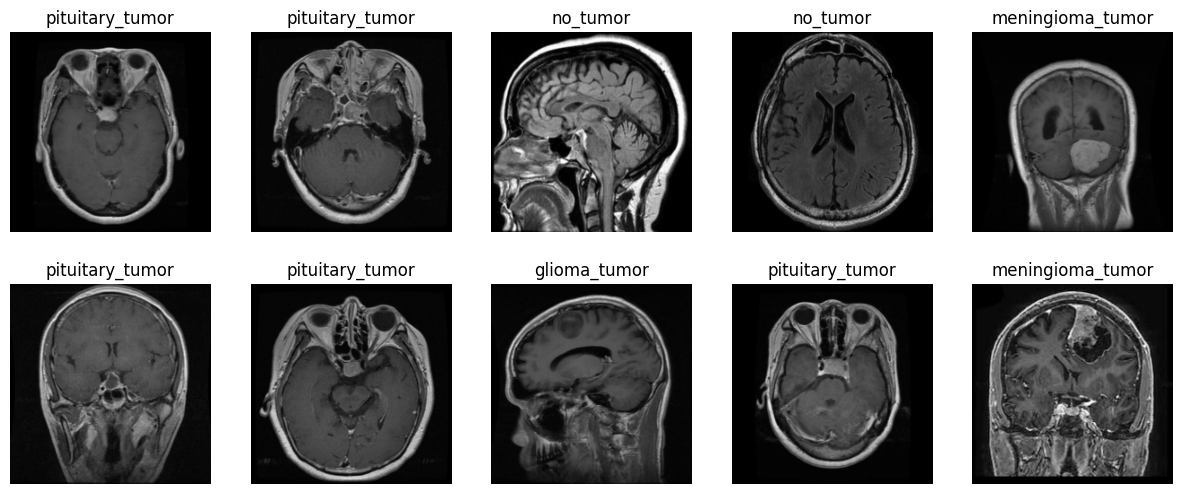

In [3]:
train_path = "../Brain-Tumor-Classification-DataSet/Training/"
test_path = "../Brain-Tumor-Classification-DataSet/Testing/"
    
    
train_dblock = DataBlock(blocks = [ImageBlock,CategoryBlock],
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = TrainTestSplitter(test_size=0.2,random_state=32),
                   item_tfms = Resize(224),
                   batch_tfms = aug_transforms(mult=2,do_flip=True,flip_vert=True))

dl = train_dblock.dataloaders(train_path)

dl.valid.show_batch(max_n=10,nrows=2)

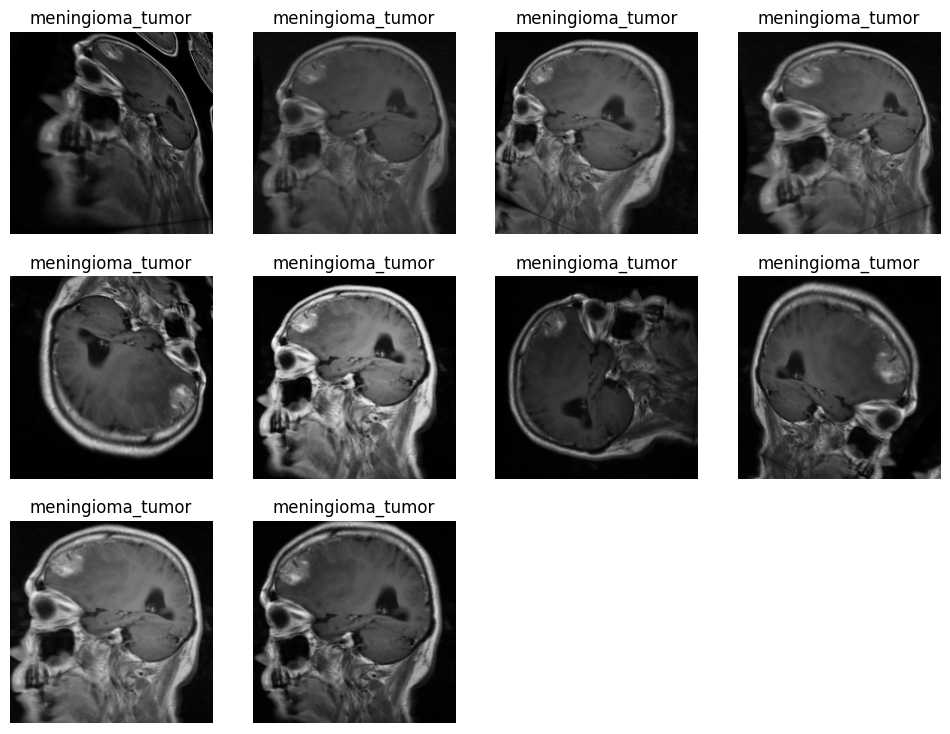

In [4]:
dl.train.show_batch(max_n=10,unique=True)

# check split

In [5]:
# *dls.xxx_ds returns tuples split into parts..zip reassembles into x/y vectors ...
x,y = zip(*dl.train_ds)
xv,yv = zip(*dl.valid_ds)

# this creates our labels list.  basically transform fastai.tensor object to a simple list of ints 
y_labels = list(map(lambda a : a.item() ,y))
yv_labels = list(map(lambda a : a.item() ,yv))
# Create a dataframe of categorical counts
df=pd.DataFrame([
    pd.Series(y_labels).value_counts(),
    pd.Series(yv_labels).value_counts()
   ]).T
# Add percentages..
df.columns = ["train","valid"]
df["train_pct"] = df["train"]/df["train"].sum()
df["valid_pct"] = df["valid"]/df["valid"].sum()
df["labels"] = pd.Series(dl.vocab)
display(df)

,train,valid,train_pct,valid_pct,labels
3,673,154,0.293118,0.268293,pituitary_tumor
0,668,158,0.290941,0.275261,glioma_tumor
1,645,177,0.280923,0.308362,meningioma_tumor
2,310,85,0.135017,0.148084,no_tumor


# Carry out experiments using VertexAI experiments -- autolog

In [6]:
from google.cloud import aiplatform

In [7]:
#!pip install google-cloud-aiplatform[autologging]  # install mlflow thorugh aiplatform

In [40]:
# Initialize Vertex AI Experiments
PROJECT_ID = ""  # Replace with your GCP project ID
REGION = ""  # Replace with your GCP region
EXPERIMENT_NAME = ""


aiplatform.init(
    experiment=EXPERIMENT_NAME,
    project=PROJECT_ID,
    location=REGION)


# Add tensorboard to experiment

In [41]:
experiment_tensorboard = aiplatform.Tensorboard.create()
tensorboard_name = experiment_tensorboard.resource_name
print("Tensorboard resource name ", tensorboard_name)

Creating Tensorboard
Create Tensorboard backing LRO: projects/889048037208/locations/asia-northeast1/tensorboards/364123066747322368/operations/6675872314774519808
Tensorboard created. Resource name: projects/889048037208/locations/asia-northeast1/tensorboards/364123066747322368
To use this Tensorboard in another session:
tb = aiplatform.Tensorboard('projects/889048037208/locations/asia-northeast1/tensorboards/364123066747322368')
Tensorboard resource name  projects/889048037208/locations/asia-northeast1/tensorboards/364123066747322368


In [42]:
metrics = [error_rate, accuracy,
          Precision(average='macro'),
          Recall(average='macro'),
          F1Score(average='macro')]

callbacks = [
    #ShowGraphCallback(),
    SaveModelCallback(monitor="valid_loss", with_opt=True),
    #CSVLogger(fname=f"{exp_dir}/results/history.csv"),
    EarlyStoppingCallback(monitor="valid_loss", patience=5)
]

metaparams = {}
hyperparams = {}

#metaparams["dev_name"] = ""  # add any other metaparams/hypterparams to track
# List of backbone architectures
backbones = [resnet18, resnet34, resnet50, resnet101, resnet152]
epochs = 20

In [43]:
aiplatform.autolog()
# Iterate over each backbone and run the experiment
for i, backbone in enumerate(backbones):
    exp_run = f"run-{i+1}"
    print(f"Running {exp_run} with backbone {backbone.__name__}")
    
    try:
        aiplatform.start_run(exp_run,resume=True)
    except Exception as e:
        # If run doesn't exist yet, create a new one
        if "Resource not found" in str(e):
            aiplatform.start_run(exp_run, resume=False)
        else:
            raise e
    # Initialize the learner with the current backbone
    learn = vision_learner(
        dls=dl,
        arch=backbone,
        metrics=metrics,
        cbs=callbacks
    )
        
    ## TODO- make dataset artifact 
    
    
    # make model artifact 
    
    #MODEL_URI = f"/home/jupyter/teamrock/fastai/models/{exp_run}_model.pth"
    
    model_artifact = aiplatform.Artifact.create(schema_title="system.Model",
                                                display_name=f"{exp_run}_model",
                                                uri=MODEL_URI)
    
    # log backbone as a parameter
    metaparams["backbone"] = f"{backbone.__name__}"
    aiplatform.log_params(metaparams)
    
    # Start a new execution context for the training process
    #Create and starts a new Metadata Execution or resumes a previously created Execution.
    with aiplatform.start_execution(schema_title="system.ContainerExecution",
                                   display_name=f"{exp_run}") as execution:
        
        # Fit the model
        learn.fit_one_cycle(epochs)    # note metrics are autologged

        # Save the model
        model_path = f"{exp_run}_model"
        learn.save(model_path)

        # Log the model artifact to Vertex AI
        #aiplatform.log_artifact(model_path)
        
    
    aiplatform.end_run()
aiplatform.autolog(disable=True)

Running run-1 with backbone resnet18
Associating projects/889048037208/locations/asia-northeast1/metadataStores/default/contexts/example-exp-tracking-run-1 to Experiment: example-exp-tracking


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,2.162550,1.479341,0.560976,0.439024,0.450988,0.442077,0.399056,00:07
1,1.622604,0.732417,0.268293,0.731707,0.734138,0.743147,0.728027,00:07
2,1.257497,0.657470,0.219512,0.780488,0.791286,0.797199,0.776156,00:06
3,1.033531,0.558616,0.189895,0.810105,0.817622,0.823851,0.810570,00:06
4,0.889344,0.490931,0.168990,0.831010,0.839831,0.846863,0.830875,00:06
5,0.755080,0.410720,0.139373,0.860627,0.868676,0.867395,0.862770,00:06
6,0.645804,0.406069,0.121951,0.878049,0.882204,0.881813,0.880381,00:06
7,0.560758,0.369562,0.114983,0.885017,0.888320,0.887761,0.884163,00:06
8,0.516455,0.318253,0.106272,0.893728,0.896841,0.897881,0.894282,00:06
9,0.459894,0.302860,0.094077,0.905923,0.908325,0.910866,0.907414,00:06


Better model found at epoch 0 with valid_loss value: 1.4793410301208496.
Better model found at epoch 1 with valid_loss value: 0.7324166893959045.
Better model found at epoch 2 with valid_loss value: 0.6574699282646179.
Better model found at epoch 3 with valid_loss value: 0.5586157441139221.
Better model found at epoch 4 with valid_loss value: 0.4909310042858124.
Better model found at epoch 5 with valid_loss value: 0.41072046756744385.
Better model found at epoch 6 with valid_loss value: 0.40606868267059326.
Better model found at epoch 7 with valid_loss value: 0.36956170201301575.
Better model found at epoch 8 with valid_loss value: 0.31825339794158936.
Better model found at epoch 9 with valid_loss value: 0.30285951495170593.
Better model found at epoch 11 with valid_loss value: 0.2937019169330597.
Better model found at epoch 12 with valid_loss value: 0.2900274693965912.
Better model found at epoch 13 with valid_loss value: 0.27883633971214294.
Better model found at epoch 14 with valid_

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,1.973862,1.152457,0.480836,0.519164,0.555806,0.501123,0.498948,00:07
1,1.541297,0.766484,0.259582,0.740418,0.740314,0.761445,0.727030,00:08
2,1.206719,0.638316,0.212544,0.787456,0.791025,0.797665,0.780952,00:07
3,0.993171,0.573187,0.189895,0.810105,0.818148,0.824180,0.803722,00:07
4,0.808878,0.471329,0.135889,0.864111,0.864260,0.873061,0.864507,00:07
5,0.694613,0.443694,0.125436,0.874564,0.875189,0.886420,0.876003,00:07
6,0.628284,0.374351,0.116725,0.883275,0.883909,0.888598,0.884021,00:07
7,0.540202,0.387944,0.109756,0.890244,0.891380,0.906179,0.892284,00:07
8,0.475655,0.389723,0.111498,0.888502,0.890414,0.902687,0.891562,00:07
9,0.411698,0.363873,0.099303,0.900697,0.905736,0.911596,0.904481,00:07


Better model found at epoch 0 with valid_loss value: 1.152456521987915.
Better model found at epoch 1 with valid_loss value: 0.7664843797683716.
Better model found at epoch 2 with valid_loss value: 0.6383159756660461.
Better model found at epoch 3 with valid_loss value: 0.5731869339942932.
Better model found at epoch 4 with valid_loss value: 0.4713287949562073.
Better model found at epoch 5 with valid_loss value: 0.4436938166618347.
Better model found at epoch 6 with valid_loss value: 0.37435072660446167.
Better model found at epoch 9 with valid_loss value: 0.36387279629707336.
Better model found at epoch 11 with valid_loss value: 0.31376346945762634.
No improvement since epoch 11: early stopping
Running run-3 with backbone resnet50
Associating projects/889048037208/locations/asia-northeast1/metadataStores/default/contexts/example-exp-tracking-run-3 to Experiment: example-exp-tracking


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,1.863891,1.133307,0.418118,0.581882,0.604832,0.614942,0.546262,00:13
1,1.387000,0.767410,0.270035,0.729965,0.728024,0.751628,0.730427,00:13
2,1.131251,0.655665,0.233449,0.766551,0.776052,0.790713,0.765963,00:13
3,0.972293,0.562731,0.198606,0.801394,0.808452,0.811230,0.804777,00:13
4,0.848950,0.496957,0.167247,0.832753,0.832864,0.846155,0.834796,00:13
5,0.762489,0.511428,0.156794,0.843206,0.840548,0.859257,0.845091,00:13
6,0.661071,0.460264,0.134146,0.865854,0.865582,0.875750,0.869455,00:13
7,0.596526,0.426331,0.125436,0.874564,0.872549,0.883023,0.876942,00:13
8,0.531533,0.420327,0.137631,0.862369,0.864810,0.868468,0.865600,00:13
9,0.494755,0.412213,0.135889,0.864111,0.864025,0.872171,0.866193,00:13


Better model found at epoch 0 with valid_loss value: 1.1333072185516357.
Better model found at epoch 1 with valid_loss value: 0.7674100399017334.
Better model found at epoch 2 with valid_loss value: 0.655665397644043.
Better model found at epoch 3 with valid_loss value: 0.5627310872077942.
Better model found at epoch 4 with valid_loss value: 0.4969567358493805.
Better model found at epoch 6 with valid_loss value: 0.4602641463279724.
Better model found at epoch 7 with valid_loss value: 0.4263312518596649.
Better model found at epoch 8 with valid_loss value: 0.4203273057937622.
Better model found at epoch 9 with valid_loss value: 0.4122132360935211.
Better model found at epoch 10 with valid_loss value: 0.37472468614578247.
Better model found at epoch 11 with valid_loss value: 0.35011041164398193.
Better model found at epoch 12 with valid_loss value: 0.33737578988075256.
Better model found at epoch 14 with valid_loss value: 0.32632556557655334.
Better model found at epoch 15 with valid_lo

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,1.846600,1.340048,0.534843,0.465157,0.535646,0.503617,0.441680,00:17
1,1.429580,0.795108,0.290941,0.709059,0.711102,0.744407,0.703912,00:21
2,1.178063,0.653799,0.217770,0.782230,0.785964,0.806471,0.779388,00:18
3,1.023208,0.652657,0.200348,0.799652,0.806036,0.826593,0.798036,00:17
4,0.895453,0.664597,0.189895,0.810105,0.810978,0.834892,0.810827,00:20
5,0.802506,0.601207,0.181185,0.818815,0.827613,0.839365,0.820853,00:17
6,0.705033,0.462937,0.151568,0.848432,0.850110,0.865538,0.850840,00:17
7,0.639852,0.478950,0.153310,0.846690,0.851030,0.856014,0.848302,00:17
8,0.587190,0.439113,0.148084,0.851916,0.859885,0.863262,0.853836,00:17
9,0.538689,0.408522,0.135889,0.864111,0.863101,0.879182,0.864528,00:17


Better model found at epoch 0 with valid_loss value: 1.3400484323501587.
Better model found at epoch 1 with valid_loss value: 0.7951075434684753.
Better model found at epoch 2 with valid_loss value: 0.6537986993789673.
Better model found at epoch 3 with valid_loss value: 0.652657151222229.
Better model found at epoch 5 with valid_loss value: 0.60120689868927.
Better model found at epoch 6 with valid_loss value: 0.46293672919273376.
Better model found at epoch 8 with valid_loss value: 0.43911251425743103.
Better model found at epoch 9 with valid_loss value: 0.40852195024490356.
Better model found at epoch 10 with valid_loss value: 0.37478527426719666.
Better model found at epoch 11 with valid_loss value: 0.3558180034160614.
Better model found at epoch 12 with valid_loss value: 0.3249707520008087.
Better model found at epoch 14 with valid_loss value: 0.31305742263793945.
Better model found at epoch 15 with valid_loss value: 0.29129713773727417.
Better model found at epoch 17 with valid_l

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,1.837415,1.161093,0.510453,0.489547,0.550172,0.530848,0.492168,00:23
1,1.456010,0.963001,0.308362,0.691638,0.715460,0.731919,0.668587,00:24
2,1.169540,0.760916,0.233449,0.766551,0.779402,0.790697,0.763985,00:23
3,0.982163,0.539333,0.168990,0.831010,0.833476,0.845505,0.834842,00:23
4,0.851075,0.533752,0.168990,0.831010,0.842847,0.844398,0.832988,00:23
5,0.744881,0.476060,0.141115,0.858885,0.865349,0.867851,0.865594,00:23
6,0.652259,0.383302,0.123693,0.876307,0.878252,0.887540,0.881267,00:23
7,0.583336,0.374476,0.118467,0.881533,0.881768,0.893939,0.885488,00:23
8,0.526092,0.389937,0.116725,0.883275,0.886801,0.889787,0.885084,00:23
9,0.470582,0.365778,0.108014,0.891986,0.892775,0.900586,0.893251,00:23


Better model found at epoch 0 with valid_loss value: 1.1610934734344482.
Better model found at epoch 1 with valid_loss value: 0.9630007743835449.
Better model found at epoch 2 with valid_loss value: 0.7609163522720337.
Better model found at epoch 3 with valid_loss value: 0.5393326878547668.
Better model found at epoch 4 with valid_loss value: 0.5337520241737366.
Better model found at epoch 5 with valid_loss value: 0.4760599732398987.
Better model found at epoch 6 with valid_loss value: 0.38330161571502686.
Better model found at epoch 7 with valid_loss value: 0.37447553873062134.
Better model found at epoch 9 with valid_loss value: 0.3657778799533844.
Better model found at epoch 10 with valid_loss value: 0.32184118032455444.
Better model found at epoch 11 with valid_loss value: 0.2825857102870941.
Better model found at epoch 12 with valid_loss value: 0.2820563316345215.
Better model found at epoch 13 with valid_loss value: 0.2724626660346985.
Better model found at epoch 14 with valid_lo

# Check experiment run and results 

In [44]:
experiment = aiplatform.Experiment(EXPERIMENT_NAME)

In [45]:
experiment.get_data_frame()

,experiment_name,run_name,run_type,state,param.mom_final,param.n_epoch,param.start_epoch,param.opt_func,param.mom_max,param.input_size,...,metric.accuracy,metric.error_rate,time_series_metric.accuracy,time_series_metric.epoch,time_series_metric.precision_score,time_series_metric.recall_score,time_series_metric.train_loss,time_series_metric.valid_loss,time_series_metric.error_rate,time_series_metric.f1_score
0,example-exp-tracking,run-5,system.ExperimentRun,COMPLETE,0.949956141588584,20,0,Adam,0.95,['64 x 3 x 224 x 224'],...,0.489547,0.510453,0.925087,19.0,0.924139,0.935112,0.282439,0.253202,0.074913,0.928166
1,example-exp-tracking,run-4,system.ExperimentRun,COMPLETE,0.949956141588584,20,0,Adam,0.95,['64 x 3 x 224 x 224'],...,0.465157,0.534843,0.886760,19.0,0.885038,0.900431,0.337944,0.284277,0.113240,0.889454
2,example-exp-tracking,run-3,system.ExperimentRun,COMPLETE,0.949956141588584,20,0,Adam,0.95,['64 x 3 x 224 x 224'],...,0.581882,0.418118,0.890244,19.0,0.892379,0.899812,0.331629,0.318908,0.109756,0.894717
3,example-exp-tracking,run-2,system.ExperimentRun,COMPLETE,0.949956141588584,20,0,Adam,0.95,['64 x 3 x 224 x 224'],...,0.519164,0.480836,0.914634,16.0,0.914570,0.921536,0.291214,0.348827,0.085366,0.915256
4,example-exp-tracking,run-1,system.ExperimentRun,COMPLETE,0.949956141588584,20,0,Adam,0.95,['64 x 3 x 224 x 224'],...,0.439024,0.560976,0.919861,19.0,0.924552,0.921187,0.294117,0.254213,0.080139,0.921025


In [4]:
#experiment.dashboard_url

In [5]:
#experiment_tensorboard.delete()